In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../beit2')
from datamodules import DATAMODULE_REGISTRY
from models import MODEL_REGISTRY
import torch
from pytorch_lightning import LightningModule
import pytorch_lightning as pl
from rich.progress import track
import matplotlib
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import textwrap
plt.rcParams["axes.axisbelow"] = False
matplotlib.rcParams.update({'font.size': 12})

KeyboardInterrupt: 

In [2]:
pl.seed_everything(0)

Seed set to 0


0

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
@torch.no_grad()
def get_embeddings(model, dataloader, device):
    img_embeds = []
    text_embeds = []
    img_ids = []
    images = []
    texts = []

    for batch in track(dataloader):
        image = batch['image'].to(device)
        text = batch['text'].to(device)
        padding_mask = batch['padding_mask'].to(device) if 'padding_mask' in batch else None
        # encoding also normalizes the output
        img_emb = model.encode_image(image=image)['x']
        text_emb = model.encode_text(text=text, padding_mask=padding_mask)['x']
        img_embeds.append(img_emb.cpu())
        text_embeds.append(text_emb.cpu())
        img_ids.append(batch['id'].cpu())
        images.append(batch['image_raw'])
        texts.append(text.cpu())

    return img_embeds, text_embeds, images, texts, img_ids

In [5]:
def get_scores(img_embeds, text_embeds, images, texts, img_ids):
    image_feats = {} # collect all unique image features, and create mapping based on id
    raw_images = {}
    for feats, ids, img_batch in zip(img_embeds, img_ids, images):
        for i, _idx in enumerate(ids):
            idx = _idx.item()
            if idx not in image_feats:
                image_feats[idx] = feats[i]
                raw_images[idx] = img_batch[i]

    tiids = torch.cat(img_ids, dim=0)
    iids = []
    sorted_tensors = []
    sorted_images = []
    for key in sorted(image_feats.keys()):
        sorted_tensors.append(image_feats[key].view(1, -1))
        sorted_images.append(raw_images[key])
        iids.append(key)

    img_embeds = torch.cat(sorted_tensors, dim=0)
    images = torch.stack(sorted_images, dim=0)
    text_embeds = torch.cat(text_embeds, dim=0)
    texts = torch.cat(texts, dim=0)

    scores = img_embeds @ text_embeds.t()
    iids = torch.LongTensor(iids).to(scores.device)

    return scores.cpu(), images.cpu(), texts.cpu(), img_embeds.cpu(), text_embeds.cpu(), iids.cpu(), tiids.cpu()

In [6]:
def fit_text(figure, axes, text):
    bbox = axes.get_position()
    fig_width_inch = figure.get_size_inches()[0]
    axes_width_inch = bbox.width * fig_width_inch
    char_width_inch = 0.1
    max_chars_per_line = int(axes_width_inch / char_width_inch)
    wrapped_text = "\n".join(textwrap.wrap(text, width=max_chars_per_line))
    return wrapped_text

In [7]:
def disable_ticks(axes):
    axes.set_xticks([])
    axes.set_yticks([])

In [8]:
def plot_text_retrievals(n_queries, n_retrievals, scores, images, text, iids, tiids):
    num_cols = n_retrievals+2
    num_rows = n_queries

    query_indices = torch.randperm((scores.shape[0]))[:n_queries]

    topk_retrievals = scores.topk(n_retrievals, dim=1).indices
    
    topk_retrievals = topk_retrievals[query_indices]
    query_coco_ids = iids[query_indices]
    query_samples = images[query_indices]

    retrieved_samples = []
    retrieval_coco_ids = []
    for idx in topk_retrievals:
        retrieved_samples.append(text[idx])
        retrieval_coco_ids.append(tiids[idx])

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 2.5*num_rows))

    axes[0, 0].set_title("ID", fontsize=18, fontweight='bold', fontname='DejaVu Serif')
    axes[0, 1].set_title("Query", fontsize=18, fontweight='bold', fontname='DejaVu Serif')
    for r_idx, j in enumerate(range(2, num_cols), start=1):
        axes[0, j].set_title(f"Retrieval {r_idx}", fontsize=18, fontweight='bold', fontname='DejaVu Serif')

    for i, (idx, sample) in enumerate(zip(query_coco_ids, query_samples)):
        axes[i, 0].text(0.5, 0.5, idx.item(), ha='center', va='center', fontsize=12)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(sample.permute(1, 2, 0))
        disable_ticks(axes[i, 1])
        for spine in axes[i, 1].spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(1)

    for i, (indices, samples) in enumerate(zip(retrieval_coco_ids, retrieved_samples)):
        samples = tokenizer.batch_decode(samples, skip_special_tokens=True)
        for j in range(n_retrievals):
            wrapped_text = fit_text(figure=fig, axes=axes[i, j+2], text=samples[j])
            axes[i, j+2].text(0.5, 0.5, wrapped_text, ha='center', va='center', fontsize=12)
            disable_ticks(axes[i, j+2])

            if indices[j].item() == query_coco_ids[i].item():
                color = 'green'
            else:
                color = 'red'
            for spine in axes[i, j+2].spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_image_retrievals(n_queries, n_retrievals, scores, images, text, iids, tiids):
    num_cols = n_retrievals+2
    num_rows = n_queries

    scores = scores.t()

    query_indices = torch.randperm((scores.shape[0]))[:n_queries]

    topk_retrievals = scores.topk(n_retrievals, dim=1).indices
    
    topk_retrievals = topk_retrievals[query_indices]
    query_coco_ids = tiids[query_indices]
    query_samples = text[query_indices]

    retrieved_samples = []
    retrieval_coco_ids = []
    for idx in topk_retrievals:
        retrieved_samples.append(images[idx])
        retrieval_coco_ids.append(iids[idx])

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 2.5*num_rows))

    axes[0, 0].set_title("ID", fontsize=18, fontweight='bold', fontname='DejaVu Serif')
    axes[0, 1].set_title("Query", fontsize=18, fontweight='bold', fontname='DejaVu Serif')
    for r_idx, j in enumerate(range(2, num_cols), start=1):
        axes[0, j].set_title(f"Retrieval {r_idx}", fontsize=18, fontweight='bold', fontname='DejaVu Serif')

    query_samples = tokenizer.batch_decode(query_samples, skip_special_tokens=True)
    for i, (idx, sample) in enumerate(zip(query_coco_ids, query_samples)):
        axes[i, 0].text(0.5, 0.5, idx.item(), ha='center', va='center', fontsize=12)
        axes[i, 0].axis('off')
        wrapped_text = fit_text(figure=fig, axes=axes[i, 1], text=sample)
        axes[i, 1].text(0.5, 0.5, wrapped_text, ha='center', va='center', fontsize=12)
        axes[i, 1].axis('off')

    for i, (indices, samples) in enumerate(zip(retrieval_coco_ids, retrieved_samples)):
        for j in range(n_retrievals):
            axes[i, j+2].imshow(samples[j].permute(1, 2, 0))
            disable_ticks(axes[i, j+2])

            if indices[j].item() == query_coco_ids[i].item():
                color = 'green'
            else:
                color = 'red'
            for spine in axes[i, j+2].spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.show()

In [10]:
MODEL_PATH = "/workspace/models/Sx3HRe_ibn_mb/model-44632-4.0723-train.ckpt"
MODEL_NAME = "Sx3HRe"

In [11]:
flickr30k_dm_kwargs = {
    'data_path': '/workspace',
    'num_max_bpe_tokens': 64,
    'color_jitter': None,
    'beit_transforms': False,
    'crop_scale': [1.0, 1.0],
    'batch_size': 256,
    'num_workers': 8,
    'shuffle': True,
    'drop_last': False,
}

In [12]:
pl.seed_everything(42)
coco_dm = DATAMODULE_REGISTRY['flickr30'](**flickr30k_dm_kwargs)

Seed set to 42


In [13]:
coco_dm.prepare_data()
coco_dm.setup('test')

2024-10-23 11:41:11 | INFO | datasets_.base_datasets | [Flickr30Dataset]: Data already exists under: /workspace/flickr30k
2024-10-23 11:41:11 | INFO | datasets_.base_datasets | [Flickr30Dataset]: Data already exists under: /workspace/flickr30k
2024-10-23 11:41:11 | INFO | datasets_.base_datasets | [Flickr30Dataset]: Data already exists under: /workspace/flickr30k
2024-10-23 11:41:12 | INFO | datasets_.base_datasets | [Flickr30Dataset]: Load 5000 image-text pairs from /workspace/flickr30k/flickr30k.test.jsonl. 


In [14]:
dl = coco_dm.test_dataloader()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cls:LightningModule = MODEL_REGISTRY[MODEL_NAME]['module']
model = model_cls.load_from_checkpoint(MODEL_PATH, strict=False).model
model = model.to(device)
model.requires_grad_(False)
model.eval()

2024-10-23 11:41:15 | INFO | utils | Modality used: Modality.IMAGE
2024-10-23 11:41:15 | INFO | data2vec_fairseq.models.data2vec2 | making target model
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1877: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
2024-10-23 11:41:16 | INFO | utils | Loaded state dict, result: <All keys matched successfully>
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['kd_loss_mb.target_memory_bank']


Sx3HRe(
  (token_type_embeddings): Embedding(2, 768)
  (tte_scale): LayerScale()
  (shared): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0, inplace=False)
    )
    (ls1): LayerScale()
    (drop_path1): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp_(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0, inplace=False)
    )
    (ls2): LayerScale()
    (drop_path2): Identity()
  )
  (fc_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_fea

In [16]:
scores, images, texts, img_embeds, text_embeds, iids, tiids = get_scores(*get_embeddings(model, dl, device))

Output()

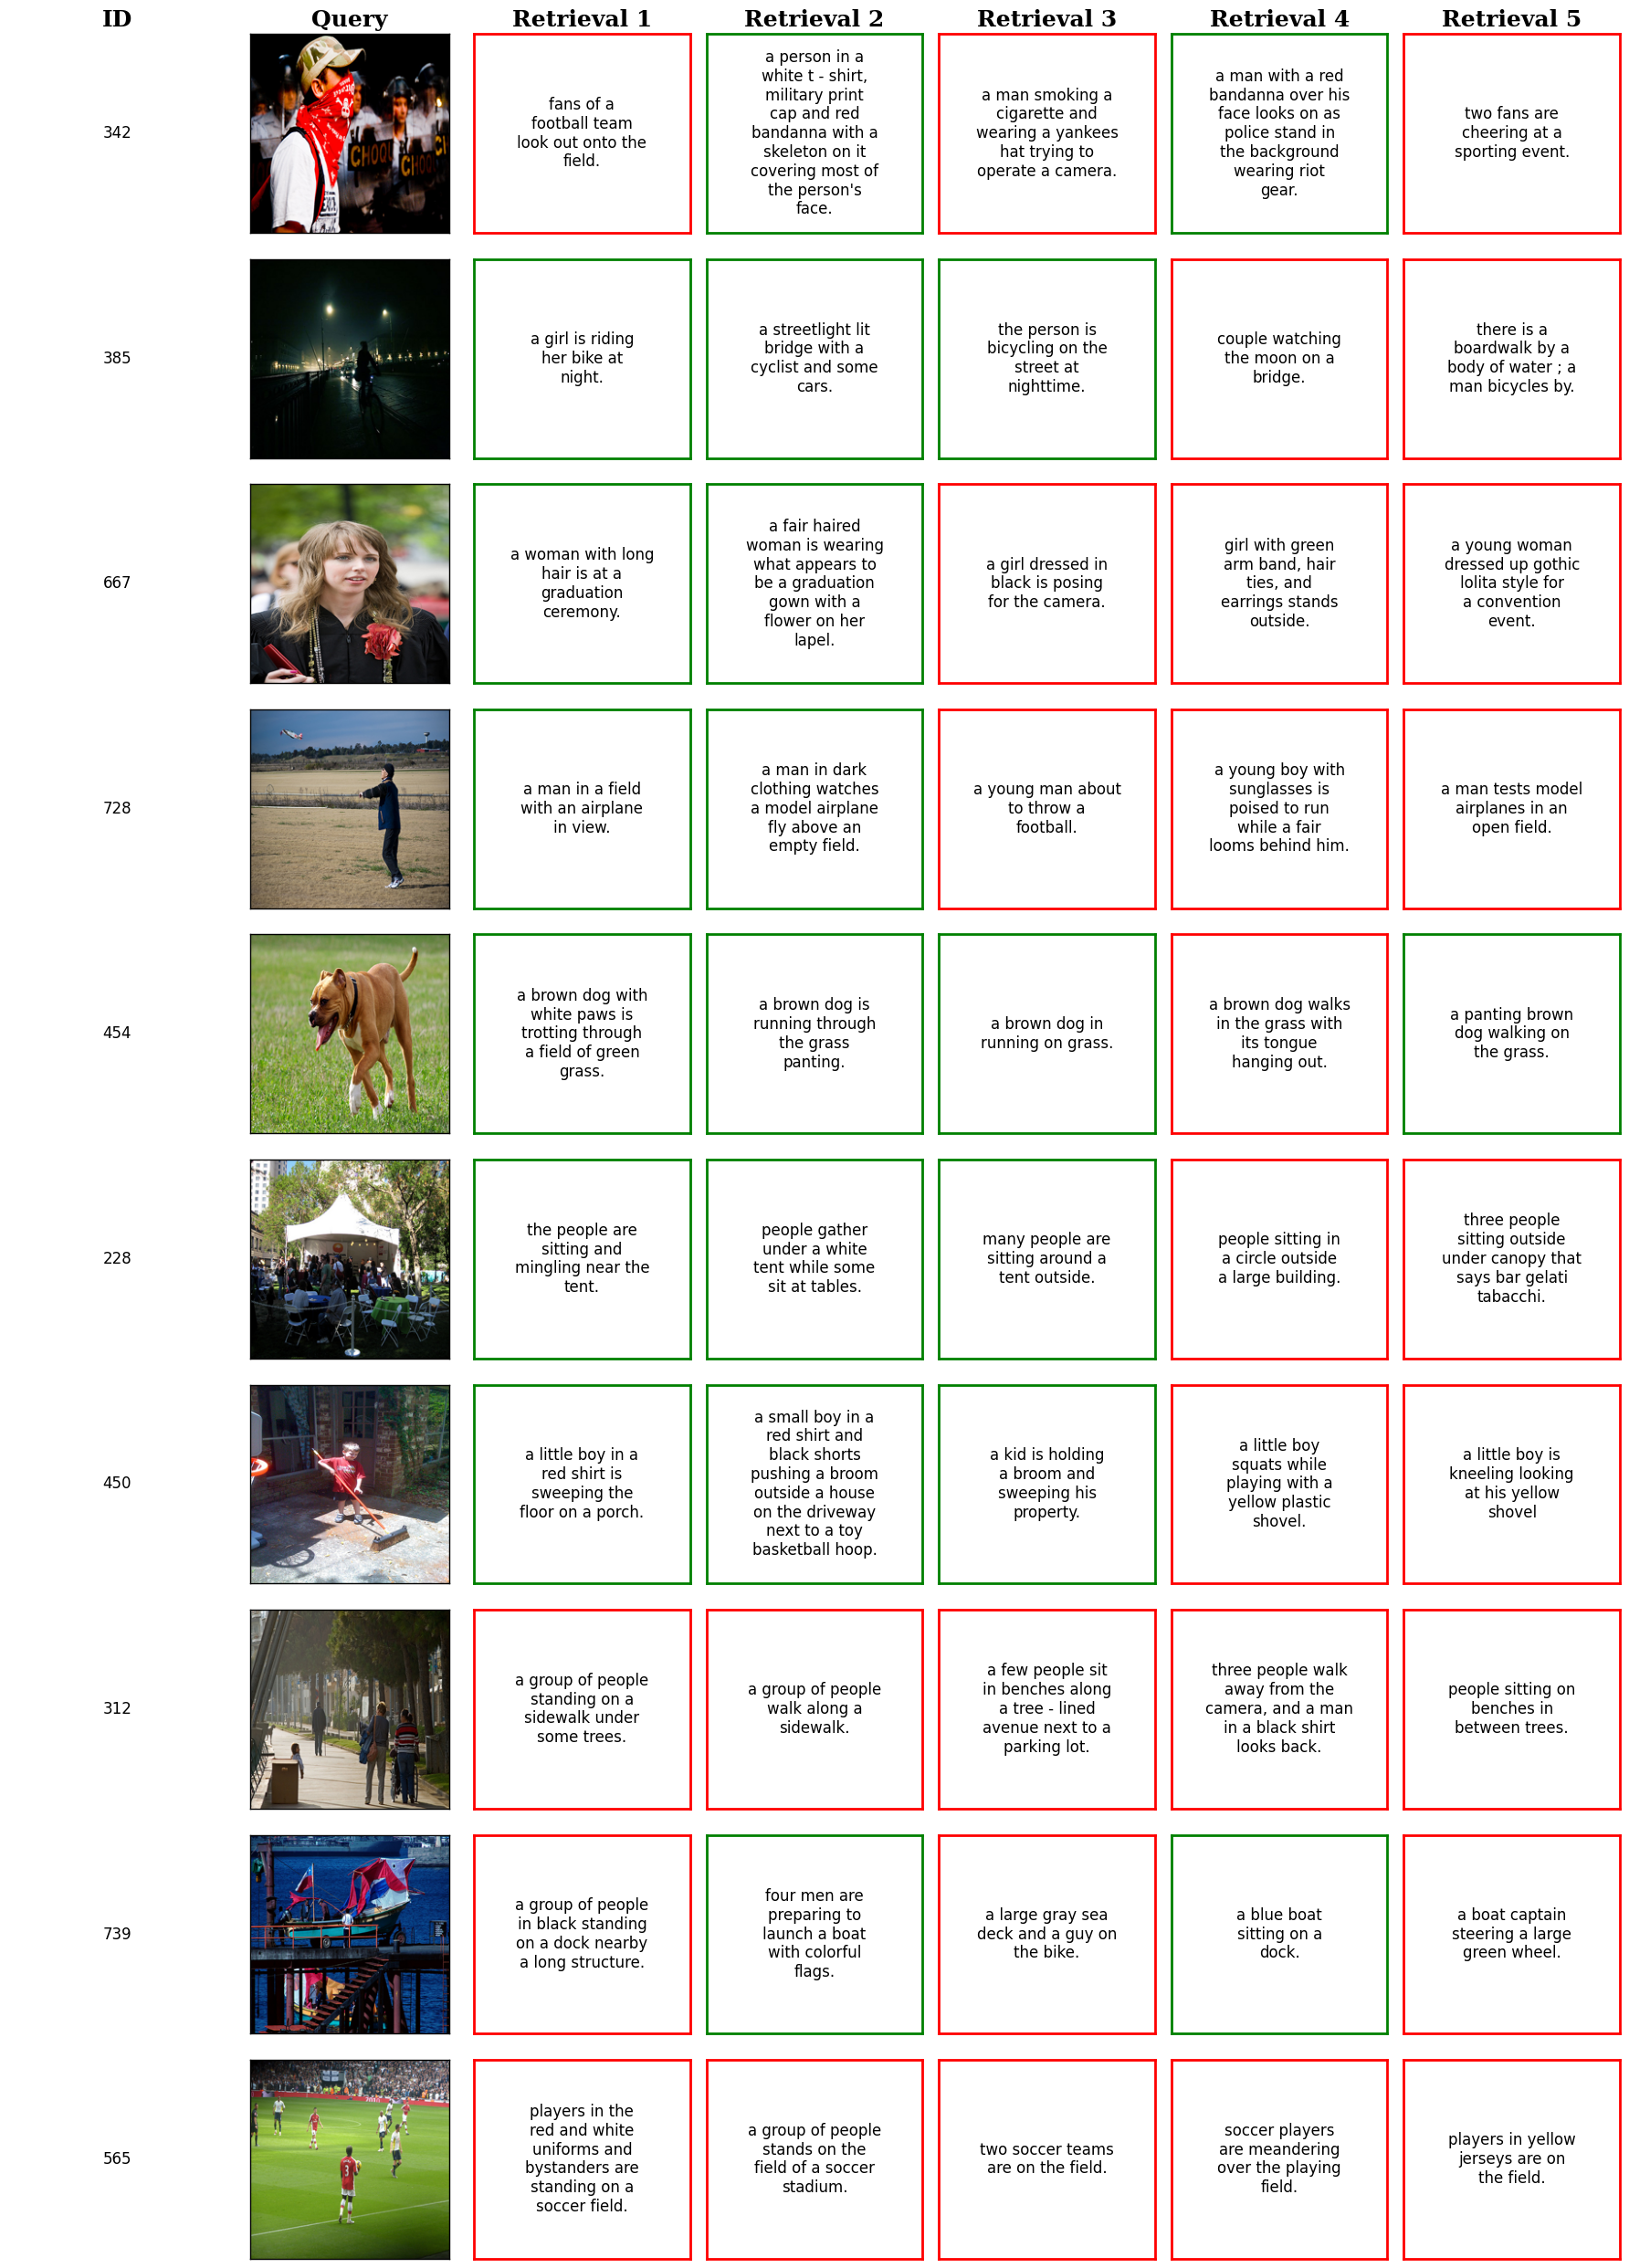

In [17]:
plot_text_retrievals(10, 5, scores, images, texts, iids, tiids)

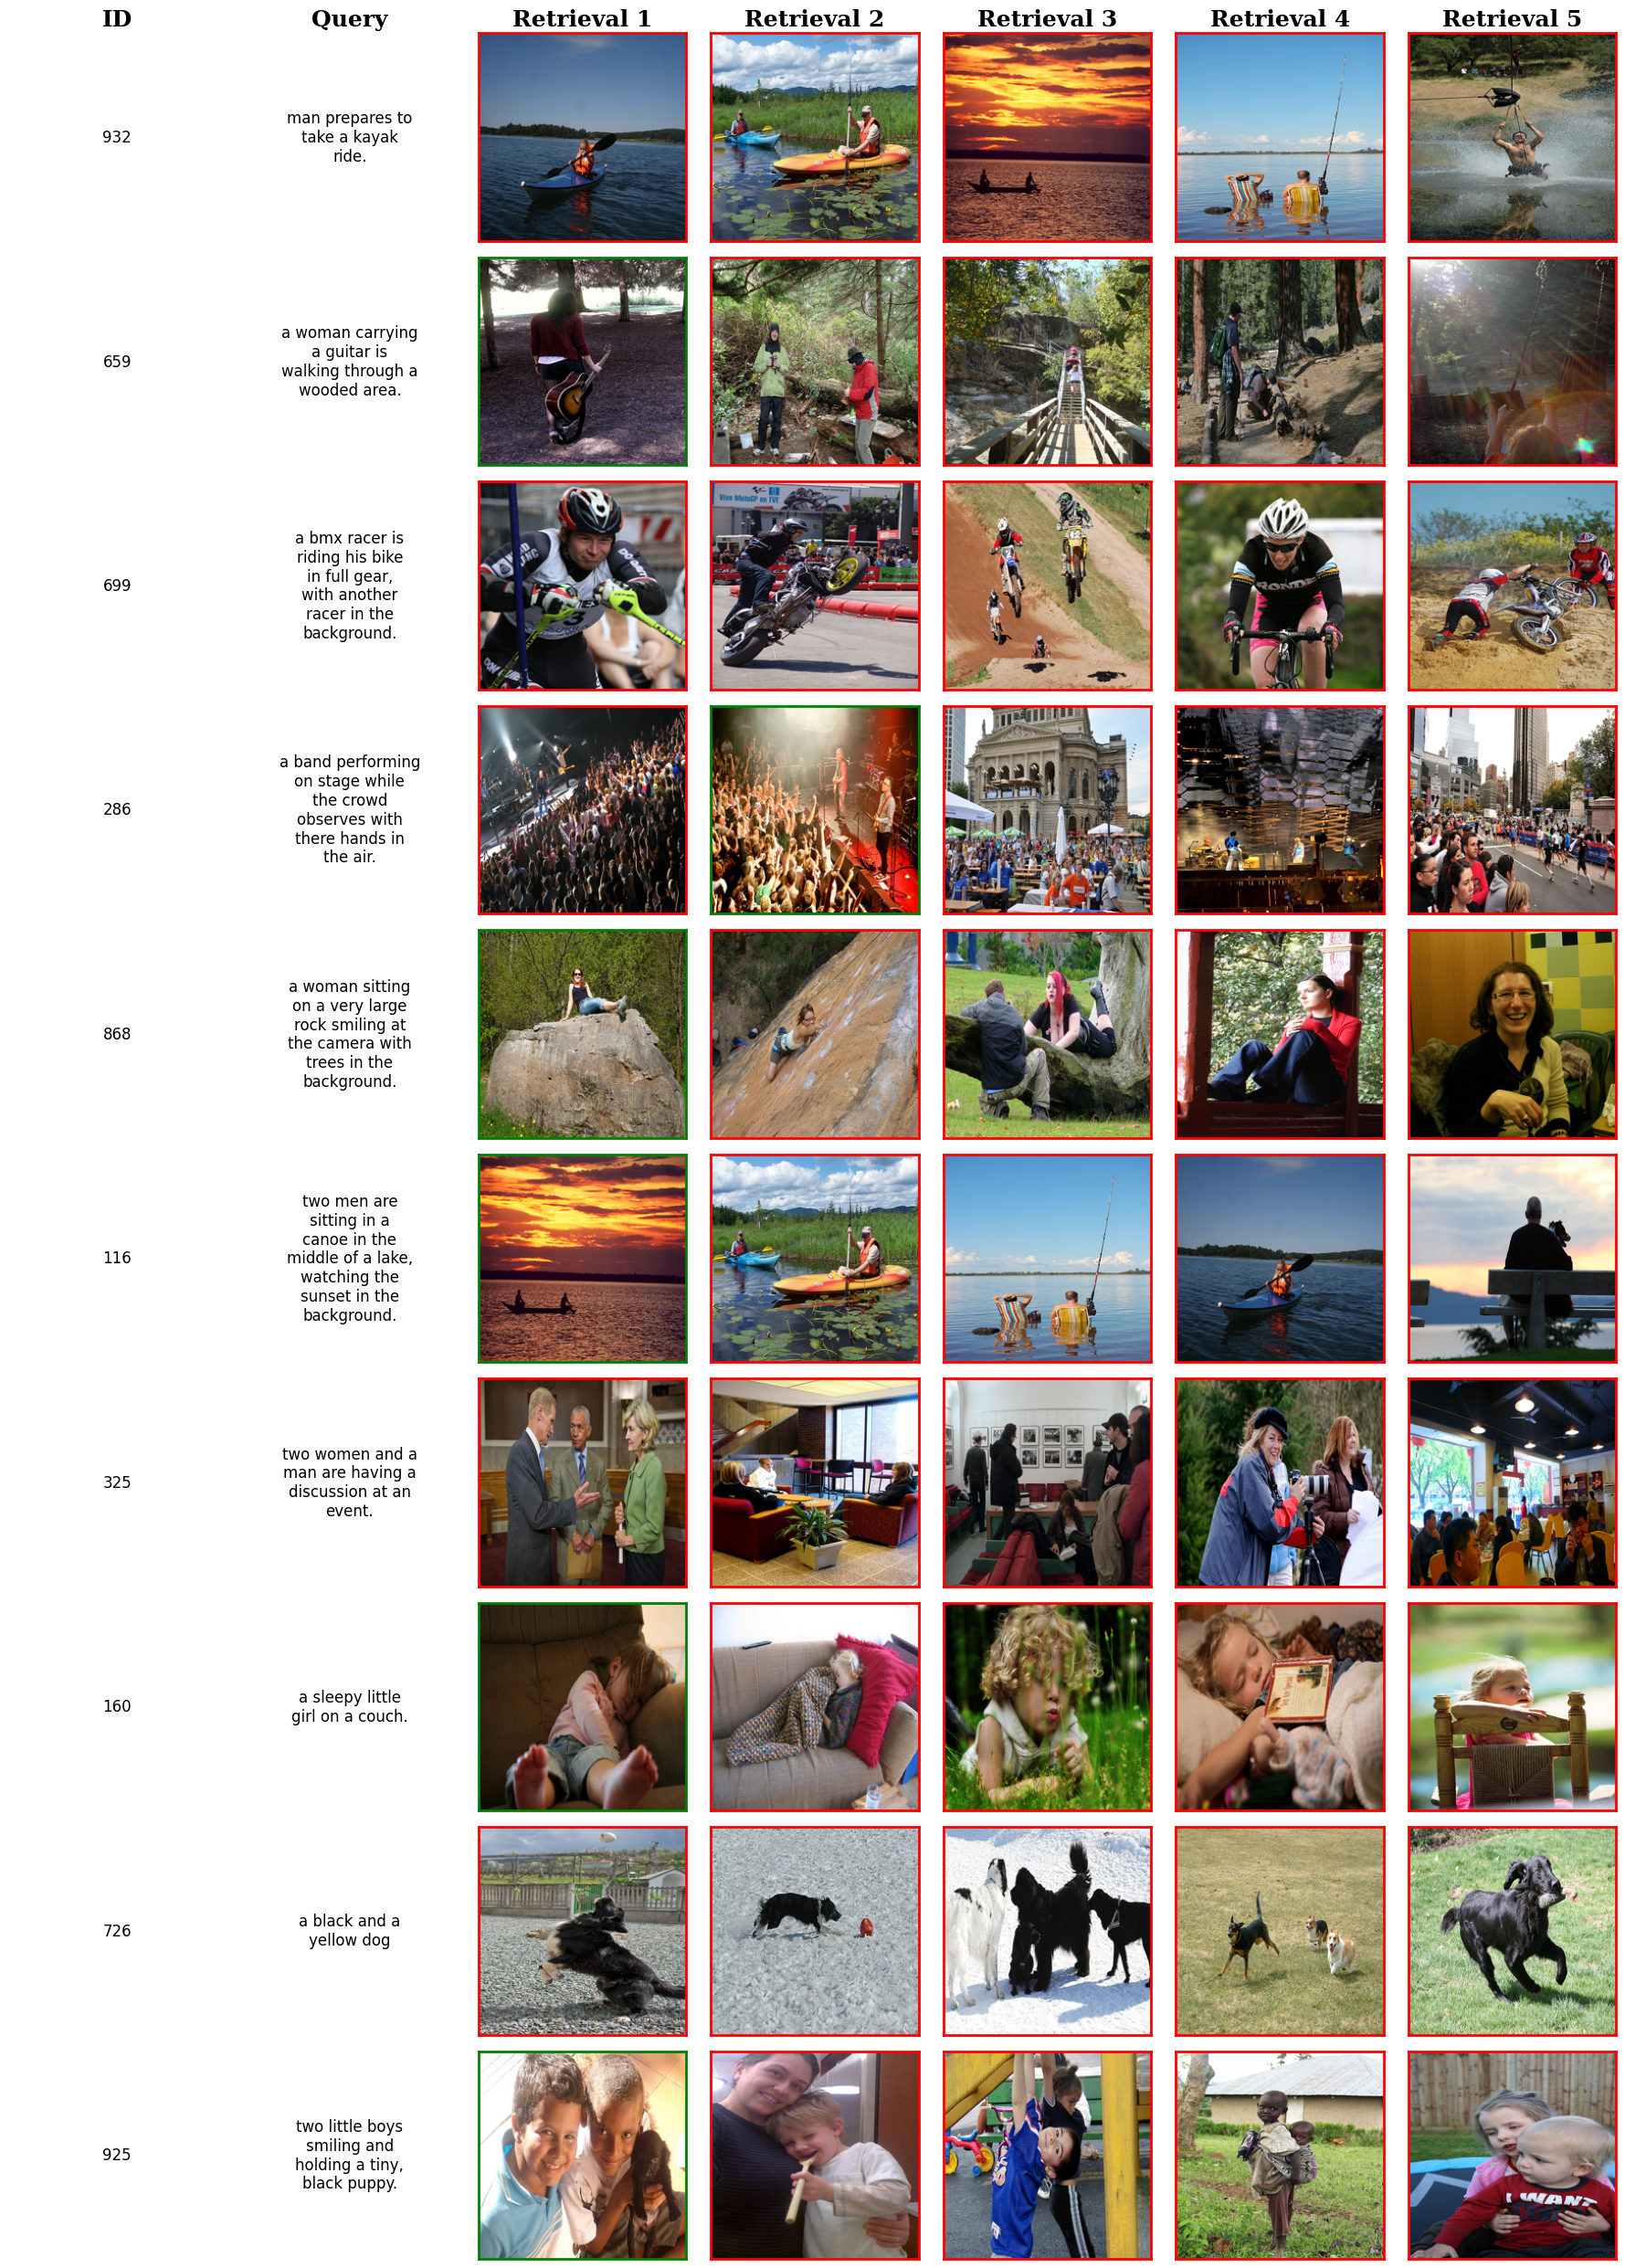

In [18]:
plot_image_retrievals(10, 5, scores, images, texts, iids, tiids)